<a href="https://colab.research.google.com/github/AR615598/Classifying_Cancer_Cells/blob/main/cancer_cell_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Identifying and Distinguishing Between Benign and Malignant Cells
Authors: Alexander Ramirez, Vaibhav Sanjay, Christine Wang, Jiaxi Tang

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# General Libraries
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt

# ML Libraries
import torch 
import keras
import sklearn
from sklearn.decomposition import PCA
import tensorflow

## Introduction
It is a common misconception that everyone has cancerous cells in their body, the reality is that our bodies are constantly producing cells that have the potential to become cancerous. Cancerous cells exhibit different behavior than normal cells, as they do not adhere to the same protocols and persistently reproduce without undergoing routine cell death. This unchecked growth leads to the development of cancerous tumors, and the spread of cancerous cells through the body. It is noteworthy that the body does not always recognize cancerous cells as foreign, and in fact, sometimes is self-sabatoges itself by supporting their growth by providing means of acheing growth throught things liek blood lines. Consequently, tumors represent the manifestation of cancer.

While it's natural to feel frightened about cancer, it's important to understand the differences between benign and malignant cells. Although benign cells are noncancerous, they can still exhibit abnormal cell growth and form tumors. The crucial difference is that benign cells cannot invade other tissues, which means they are typically not life-threatening. However, they should still be monitored because they can displace other organs. For example, a brain tumor can put pressure on sensitive areas of the brain.

On the other hand, malignant cells are typically more life-threatening because they can invade other tissues. This allows them to spread to other organs and potentially cause organ failure. The systems that allow cells to function normally are very specialized, and the invasion of malignant cells disrupts this delicate balance and causes damage. As a result, it's crucial to identify malignant cells as early as possible and take appropriate steps to prevent their spread.

Another crucial factor to consider when distinguishing between benign and malignant cells is the difference in treatment options. Benign tumors are typically treated through surgical removal, and once removed, they are unlikely to regrow as long as all the abnormal cells have been removed.

In contrast, malignant tumors can spread to other parts of the body and require more aggressive treatments, such as chemotherapy, radiation therapy, or targeted therapy, to eradicate cancerous cells throughout the body. In some cases, surgery may also be necessary to remove the primary tumor, as well as any other tumors that have developed as a result of the cancer spreading. Because of the potential for malignant cells to spread, it's important to diagnose and treat them as early as possible to increase the chances of successful treatment.
This is wny identifying cancerous cells and classifying them is so important, being able to identify benign cells allows doctors to plan accordingly with alot of information, malignant cells on the other hand are much more difficult to treat and makes treatment more difficult, but being able to identify them early will lead to drastically better outcomes. 

## Cleaning the Dataset
### About the Dataset
Let us start by taking a look at our dataset.





In [ ]:
# Loading CSV
csv = 'https://raw.githubusercontent.com/AR615598/Classifying_Cancer_Cells/main/Cancer_Data.csv'
# save as Pandas dataframe
cc = pd.read_csv(csv)
cc

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


The dataset is a comprehensive collection of information about cancer cells, providing nearly 600 examples for analysis.

In [ ]:
len(cc)

569

The dataset is a comprehensive collection of information about cancer cells, providing nearly 600 examples for analysis. Each example in the dataset is characterized by 32 columns, with 30 of them being used to describe the visual characteristics of the cell. These visual characteristics provide important information about the cancer cell, including its radius, texture, perimeter, area, smoothness, compactness, concavity, and concave points.

In [ ]:
cc.dtypes

id                           int64
diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst     

### Removing null data
Let's remove any null data, since this will not help us in any analysis.

In [ ]:
# drop not needed columns
cc = cc.drop(labels="id", axis=1)

null_cols = cc.columns[cc.isnull().any()]
if len(null_cols) == 0:
  print("No null values")
else:
  for cols in null_cols:
    print(cols)

No null values


No Null values. Great! We don't need to process non-null entries.

### Transforming Categorical Data


Since we will be applying machine learning algorithms to this data, we will need to turn all categorical data into numerical data. Normally, we would use a process called one-hot encoding. You could use the `pd.get_dummies()` function to turn the diagnosis data from strings to integers. You can find out more about this function and one-hot encoding at [this link](https://datagy.io/pandas-get-dummies/).

In [ ]:
# One hot encoding labels
cc = pd.get_dummies(cc, columns=['diagnosis'])
cc = cc.rename(columns={'diagnosis_B': 'Benign', 'diagnosis_M': 'Malignant'})

In [ ]:
cc['Benign'].value_counts()

1    357
0    212
Name: Benign, dtype: int64

###Removing Outliers
Finally, we need to get rid of any outliers in the dataset. Outliers will affect the normalization step that will come later. To combat outliers, we simply check if the [z-score](https://www.statology.org/z-score-python/) of the data point is over 3. We apply this to all columns and remove the data point if it is an outlier in any column.

In [ ]:
cc[(np.abs(scipy.stats.zscore(cc)) < 3).all(axis=1)]
len(cc)

569

It turns out that we actually don't have any outliers, and we can proceed with the entire dataset.

# Data Exploration

First, we would like to examine the relationship between benign / malignant and all other features. We would also like to see the correlation between variables for easy dimension reduction.

One way to see the correlations between many separate variables is using a [covariance matrix](https://datascienceplus.com/understanding-the-covariance-matrix/).

In [ ]:
# only interested in the covariance between benign / malignant and other variables 
cov_mat = np.cov(cc,rowvar=False)[-2:]
print(cov_mat)

[[-2.40598315e+06 -1.24495449e+00 -8.64145276e-01 -8.73243824e+00
  -1.20738222e+02 -2.44031758e-03 -1.52456362e-02 -2.68640582e-02
  -1.45827836e-02 -4.38448074e-03  4.38614198e-05 -7.61074368e-02
   2.21659602e-03 -5.44134584e-01 -1.20688191e+01  9.73724102e-05
  -2.53915769e-03 -3.70637700e-03 -1.21837841e-03  2.60886253e-05
  -9.98422189e-05 -1.81604183e+00 -1.35895895e+00 -1.27308678e+01
  -2.02184994e+02 -4.65677477e-03 -4.49973956e-02 -6.65922914e-02
  -2.52425892e-02 -1.24633432e-02 -2.83069850e-03  2.34176589e-01
  -2.34176589e-01]
 [ 2.40598315e+06  1.24495449e+00  8.64145276e-01  8.73243824e+00
   1.20738222e+02  2.44031758e-03  1.52456362e-02  2.68640582e-02
   1.45827836e-02  4.38448074e-03 -4.38614198e-05  7.61074368e-02
  -2.21659602e-03  5.44134584e-01  1.20688191e+01 -9.73724102e-05
   2.53915769e-03  3.70637700e-03  1.21837841e-03 -2.60886253e-05
   9.98422189e-05  1.81604183e+00  1.35895895e+00  1.27308678e+01
   2.02184994e+02  4.65677477e-03  4.49973956e-02  6.6592

In [ ]:
len(cov_mat[0]) == len(cc.columns[1:])

False

In [ ]:
# benign features
blist = list(zip(cov_mat[0],cc.columns[1:]))
blist

[(-1.2449544914478086, 'texture_mean'),
 (-0.8641452758731648, 'perimeter_mean'),
 (-8.732438241045571, 'area_mean'),
 (-120.73822186192729, 'smoothness_mean'),
 (-0.002440317582118369, 'compactness_mean'),
 (-0.015245636185301616, 'concavity_mean'),
 (-0.026864058180895566, 'concave points_mean'),
 (-0.01458278358375208, 'symmetry_mean'),
 (-0.004384480742097575, 'fractal_dimension_mean'),
 (4.386141983712459e-05, 'radius_se'),
 (-0.07610743675586025, 'texture_se'),
 (0.0022165960172281533, 'perimeter_se'),
 (-0.5441345843956534, 'area_se'),
 (-12.06881907349192, 'smoothness_se'),
 (9.737241020817353e-05, 'compactness_se'),
 (-0.002539157686452636, 'concavity_se'),
 (-0.0037063769981930256, 'concave points_se'),
 (-0.001218378412832001, 'symmetry_se'),
 (2.6088625337260897e-05, 'fractal_dimension_se'),
 (-9.98422188668036e-05, 'radius_worst'),
 (-1.816041832718632, 'texture_worst'),
 (-1.3589589470036385, 'perimeter_worst'),
 (-12.730867812322089, 'area_worst'),
 (-202.18499436867262,

In [ ]:
top_5_ben = sorted(blist, key=lambda x : x[0])[:8]
bottom_5_ben = sorted(blist, key=lambda x : x[0])[-8:]

print("Weakest linear indicators of Benign:")
for elt,col in top_5_ben:
    print(f"cov: {elt},\t Column: {col}")
    
print("\nStrongest linear indicators of Benign:")
for elt,col in bottom_5_ben[::-1]:
    print(f"cov: {elt},\t Column: {col}")

Weakest linear indicators of Benign:
cov: -202.18499436867262,	 Column: smoothness_worst
cov: -120.73822186192729,	 Column: smoothness_mean
cov: -12.730867812322089,	 Column: area_worst
cov: -12.06881907349192,	 Column: smoothness_se
cov: -8.732438241045571,	 Column: area_mean
cov: -1.816041832718632,	 Column: texture_worst
cov: -1.3589589470036385,	 Column: perimeter_worst
cov: -1.2449544914478086,	 Column: texture_mean

Strongest linear indicators of Benign:
cov: 0.2341765885294197,	 Column: Malignant
cov: 0.0022165960172281533,	 Column: perimeter_se
cov: 9.737241020817353e-05,	 Column: compactness_se
cov: 4.386141983712459e-05,	 Column: radius_se
cov: 2.6088625337260897e-05,	 Column: fractal_dimension_se
cov: -9.98422188668036e-05,	 Column: radius_worst
cov: -0.001218378412832001,	 Column: symmetry_se
cov: -0.002440317582118369,	 Column: compactness_mean


From the above ranking, we can see that the following are the weakest linear indicators of Benign:
* smoothness_worst
* smoothness_mean
* area_worst
* smoothness_se
* area_mean

The following are the strongest linear indicators of Benign:

* perimeter_se
* compactness_se
* radius_se
* fractal_dimension_se





In [ ]:
# malignant features
mlist = list(zip(cov_mat[1],cc.columns[1:]))

In [ ]:

top_5_mal = sorted(mlist, key=lambda x : x[0])[:8]
bottom_5_mal = sorted(mlist, key=lambda x : x[0])[-8:]

print("Weakest linear indicators of Malign:")
for elt,col in top_5_mal:
    print(f"cov: {elt}, \t Column: {col}")
    
print("\nStrongest linear indicators of Malign:")
for elt,col in bottom_5_mal[::-1]:
    print(f"cov: {elt}, \t Column: {col}")

Weakest linear indicators of Malign:
cov: -0.2341765885294197, 	 Column: Malignant
cov: -0.0022165960172281533, 	 Column: perimeter_se
cov: -9.737241020817353e-05, 	 Column: compactness_se
cov: -4.386141983712459e-05, 	 Column: radius_se
cov: -2.6088625337260897e-05, 	 Column: fractal_dimension_se
cov: 9.98422188668036e-05, 	 Column: radius_worst
cov: 0.001218378412832001, 	 Column: symmetry_se
cov: 0.002440317582118369, 	 Column: compactness_mean

Strongest linear indicators of Malign:
cov: 202.18499436867262, 	 Column: smoothness_worst
cov: 120.73822186192729, 	 Column: smoothness_mean
cov: 12.730867812322089, 	 Column: area_worst
cov: 12.06881907349192, 	 Column: smoothness_se
cov: 8.732438241045571, 	 Column: area_mean
cov: 1.816041832718632, 	 Column: texture_worst
cov: 1.3589589470036385, 	 Column: perimeter_worst
cov: 1.2449544914478086, 	 Column: texture_mean


From the above ranking, we can see that 
*  perimeter_se
*  compactness_se
*  radius_se
*  fractal_dimension_se


are positively asociated with being malignant, while
* smoothness_worst
* smoothness_mean
* area_worst
* smoothness_se
* area_mean


are barely negatively associated with being malignant



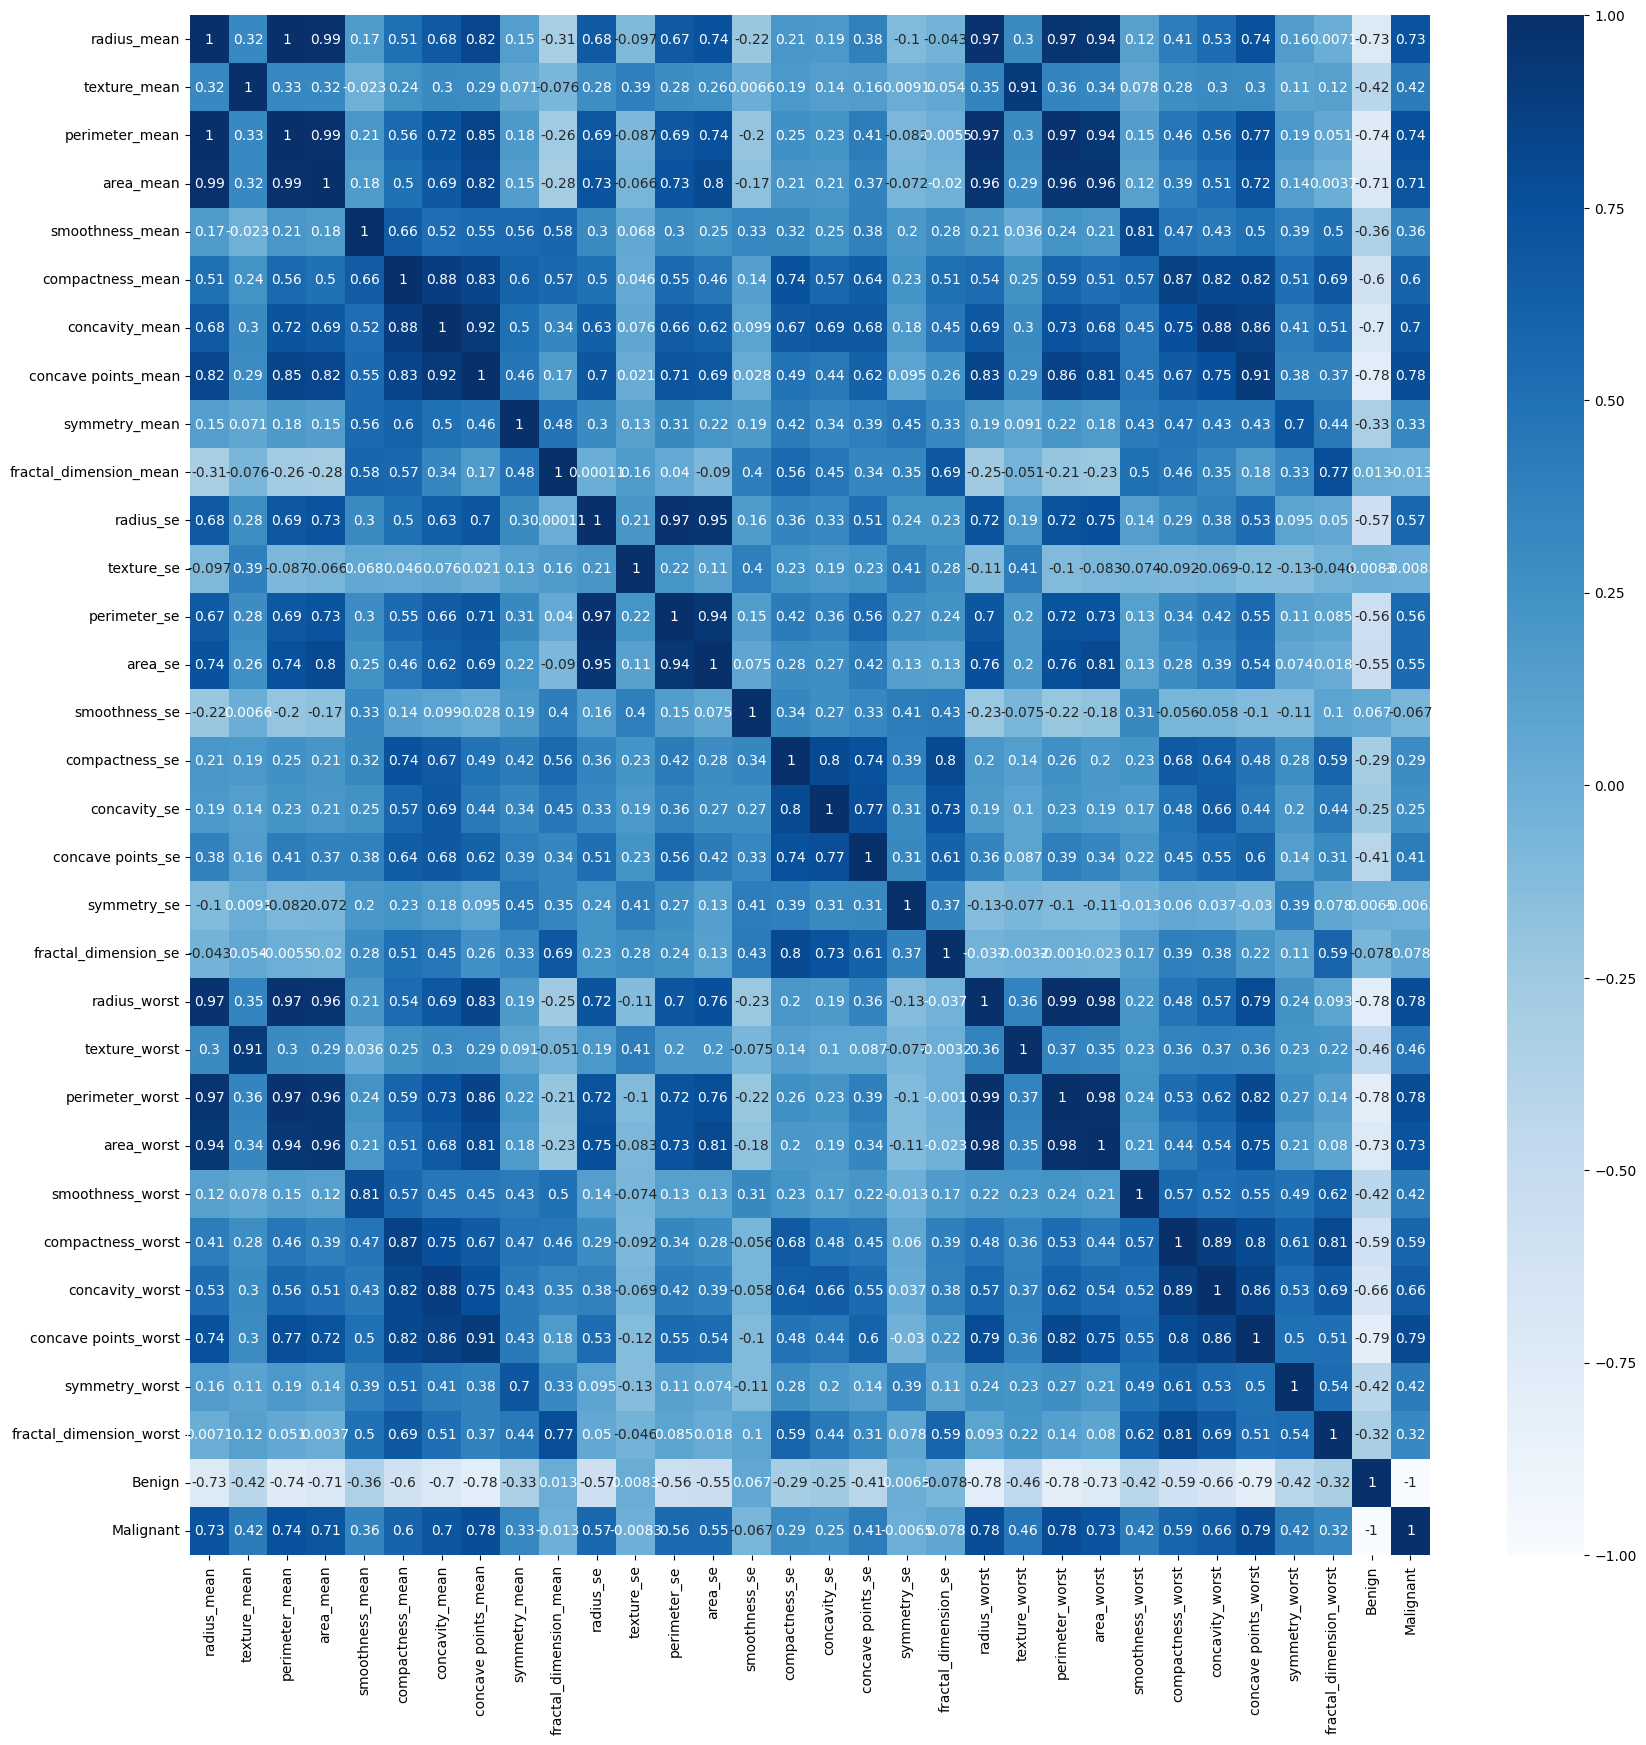

In [ ]:
# cross examine with co
plt.figure(figsize=(20,20))
sns.heatmap(cc.corr(),cbar=True,annot=True,cmap='Blues')
plt.show()

From the above heat map, we can see that benign and malignant are negatively linearly associarted with each other, so, we will only list features for benign. 


From the covariance matrix and correlation heat map, We can see that there aren't any features that are remotely definitive for being benign, but there are a lot of features that strongly associate with being malignant.

We can also use heat map to filter out highly correlated variables so that we can reduce the dimension.

In [ ]:
cc.corr().loc["Benign"].sort_values()

Malignant                 -1.000000
concave points_worst      -0.793566
perimeter_worst           -0.782914
concave points_mean       -0.776614
radius_worst              -0.776454
perimeter_mean            -0.742636
area_worst                -0.733825
radius_mean               -0.730029
area_mean                 -0.708984
concavity_mean            -0.696360
concavity_worst           -0.659610
compactness_mean          -0.596534
compactness_worst         -0.590998
radius_se                 -0.567134
perimeter_se              -0.556141
area_se                   -0.548236
texture_worst             -0.456903
smoothness_worst          -0.421465
symmetry_worst            -0.416294
texture_mean              -0.415185
concave points_se         -0.408042
smoothness_mean           -0.358560
symmetry_mean             -0.330499
fractal_dimension_worst   -0.323872
compactness_se            -0.292999
concavity_se              -0.253730
fractal_dimension_se      -0.077972
symmetry_se                0

We need to explore the data more to get an idea of the certain features that determines whether a tumor is benign or malignant. This part examines different features of tumors that were identified as benign. First we divide all the tumors that were benign and malignant into their own datasets.

In [ ]:
b_group = cc.loc[cc['Benign'] == 1]
m_group = cc.loc[cc['Malignant'] == 1]

In [ ]:
b_group.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Benign,Malignant
count,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,...,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.0,357.0
mean,12.146524,17.914762,78.075406,462.790196,0.092478,0.080085,0.046058,0.025717,0.174186,0.062867,...,87.005938,558.899440,0.124959,0.182673,0.166238,0.074444,0.270246,0.079442,1.0,0.0
std,1.780512,3.995125,11.807438,134.287118,0.013446,0.033750,0.043442,0.015909,0.024807,0.006747,...,13.527091,163.601424,0.020013,0.092180,0.140368,0.035797,0.041745,0.013804,0.0,0.0
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.051850,...,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156600,0.055210,1.0,0.0
25%,11.080000,15.150000,70.870000,378.200000,0.083060,0.055620,0.020310,0.015020,0.158000,0.058530,...,78.270000,447.100000,0.110400,0.112000,0.077080,0.051040,0.240600,0.070090,1.0,0.0
50%,12.200000,17.390000,78.180000,458.400000,0.090760,0.075290,0.037090,0.023440,0.171400,0.061540,...,86.920000,547.400000,0.125400,0.169800,0.141200,0.074310,0.268700,0.077120,1.0,0.0
75%,13.370000,19.760000,86.100000,551.100000,0.100700,0.097550,0.059990,0.032510,0.189000,0.065760,...,96.590000,670.000000,0.137600,0.230200,0.221600,0.097490,0.298300,0.085410,1.0,0.0
max,17.850000,33.810000,114.600000,992.100000,0.163400,0.223900,0.410800,0.085340,0.274300,0.095750,...,127.100000,1210.000000,0.200600,0.584900,1.252000,0.175000,0.422800,0.148600,1.0,0.0


In [ ]:
m_group.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Benign,Malignant
count,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,...,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.0,212.0
mean,17.462830,21.604906,115.365377,978.376415,0.102898,0.145188,0.160775,0.087990,0.192909,0.062680,...,141.370330,1422.286321,0.144845,0.374824,0.450606,0.182237,0.323468,0.091530,0.0,1.0
std,3.203971,3.779470,21.854653,367.937978,0.012608,0.053987,0.075019,0.034374,0.027638,0.007573,...,29.457055,597.967743,0.021870,0.170372,0.181507,0.046308,0.074685,0.021553,0.0,0.0
min,10.950000,10.380000,71.900000,361.600000,0.073710,0.046050,0.023980,0.020310,0.130800,0.049960,...,85.100000,508.100000,0.088220,0.051310,0.023980,0.028990,0.156500,0.055040,0.0,1.0
25%,15.075000,19.327500,98.745000,705.300000,0.094010,0.109600,0.109525,0.064620,0.174050,0.056598,...,119.325000,970.300000,0.130475,0.244475,0.326425,0.152750,0.276500,0.076302,0.0,1.0
50%,17.325000,21.460000,114.200000,932.000000,0.102200,0.132350,0.151350,0.086280,0.189900,0.061575,...,138.000000,1303.000000,0.143450,0.356350,0.404900,0.182000,0.310300,0.087600,0.0,1.0
75%,19.590000,23.765000,129.925000,1203.750000,0.110925,0.172400,0.203050,0.103175,0.209850,0.067075,...,159.800000,1712.750000,0.155975,0.447850,0.556175,0.210675,0.359225,0.102625,0.0,1.0
max,28.110000,39.280000,188.500000,2501.000000,0.144700,0.345400,0.426800,0.201200,0.304000,0.097440,...,251.200000,4254.000000,0.222600,1.058000,1.170000,0.291000,0.663800,0.207500,0.0,1.0


Benign tumors cells are known to be smooth compared to malignant tumors cells, we can examine features in relation to the smoothness of the cells.

In [ ]:
from sklearn.feature_selection import mutual_info_classif


X = cc.drop(['Malignant', 'Benign'], axis=1).values
y = cc['Malignant'].values

# Calculate the information gain for each feature
mi_scores = mutual_info_classif(X, y)

# Get the indices of the top 5 scores
top_5 = np.argsort(mi_scores)[::-1][:5]

print("Top 5 malignant features in terms of information gain:")
for i, feature_idx in enumerate(top_5):
    print(f"{i}. {cc.columns[feature_idx]}: {mi_scores[feature_idx]}")



Top 5 malignant features in terms of information gain:
0. perimeter_worst: 0.47823889514312645
1. area_worst: 0.4630928208739771
2. radius_worst: 0.45313570525718316
3. concave points_mean: 0.4402998831908054
4. concave points_worst: 0.43742588453351305


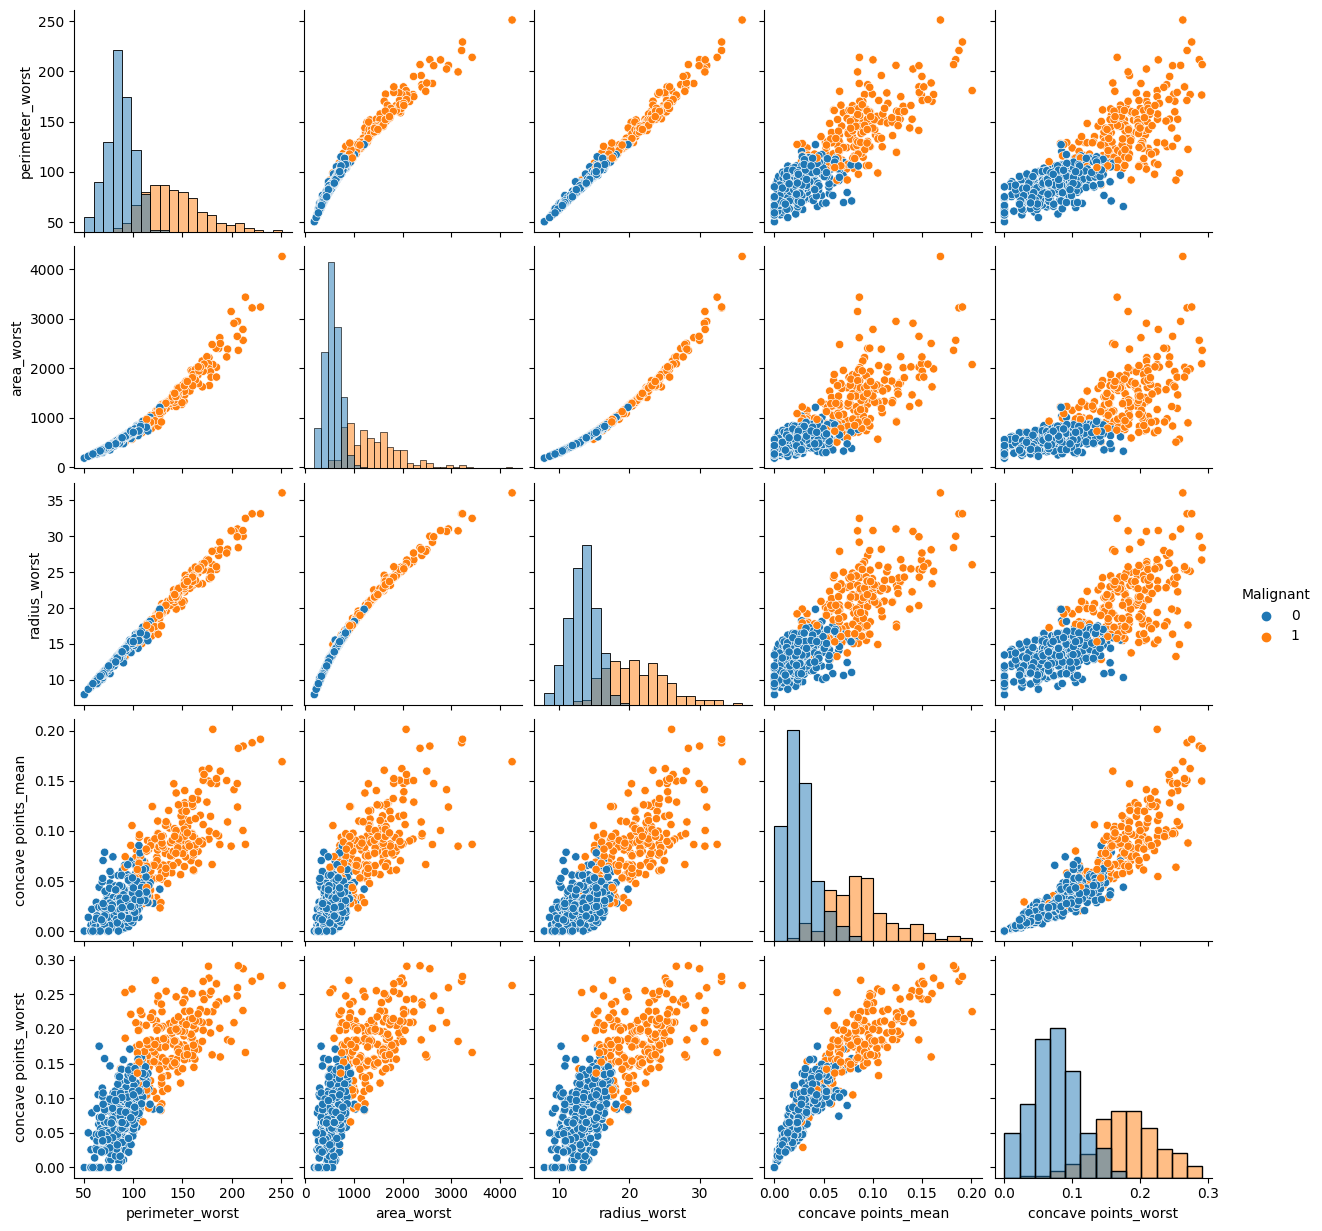

In [ ]:
# create a new dataframe with only the selected features and target variable
df = cc[cc.columns[top_5]].copy()
df['Malignant'] = cc['Malignant'].copy()
# create a pairplot with scatter plots for each feature
sns.pairplot(df, hue='Malignant', diag_kind='hist')
plt.show()


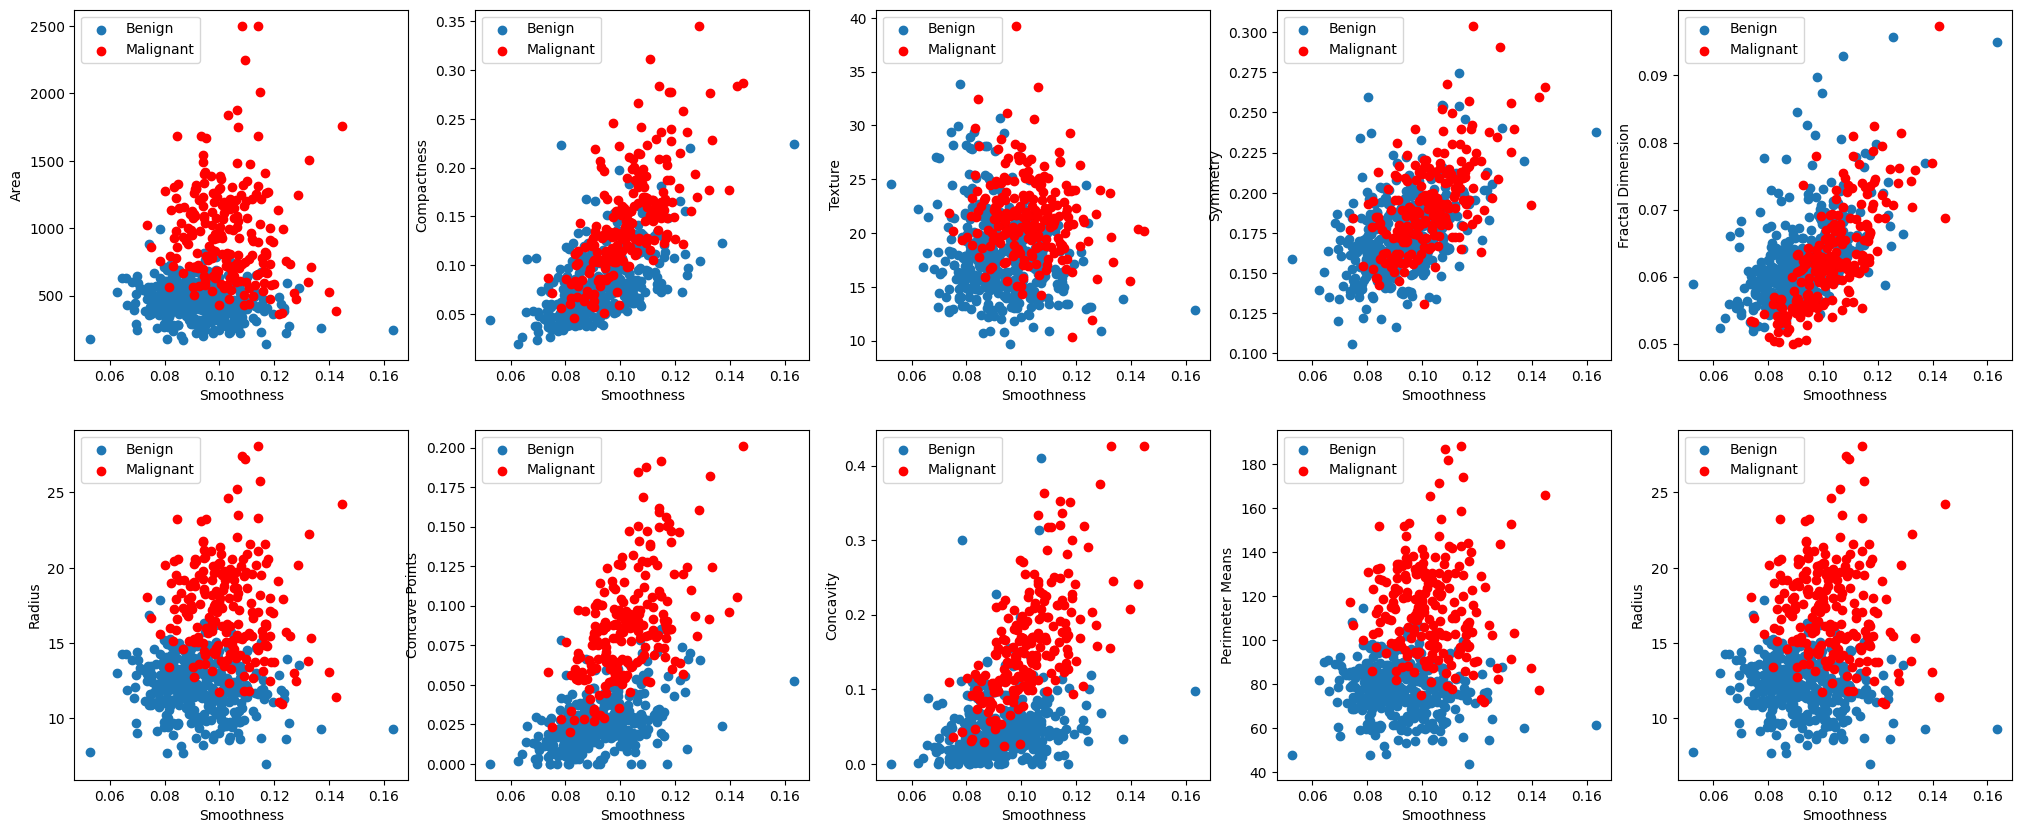

In [ ]:
# create a figure with a 2x5 grid of subplots
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(25, 10))


# flatten the axs array so we can access each subplot by index
axs = axs.flatten()


# iterate over each subplot and plot the corresponding data
for i in range(len(axs)):
    ax = axs[i]
    if i == 0:
        ax.scatter(b_group['smoothness_mean'], b_group['area_mean'], label="Benign")
        ax.scatter(m_group['smoothness_mean'], m_group['area_mean'], color='r', label="Malignant")
        ax.set_xlabel('Smoothness')
        ax.set_ylabel('Area')
        ax.legend(loc="upper left")
    elif i == 1:
        ax.scatter(b_group['smoothness_mean'], b_group['compactness_mean'], label="Benign")
        ax.scatter(m_group['smoothness_mean'], m_group['compactness_mean'], color='r', label="Malignant")
        ax.set_xlabel('Smoothness')
        ax.set_ylabel('Compactness')
        ax.legend(loc="upper left")
    elif i == 2:
        ax.scatter(b_group['smoothness_mean'], b_group['texture_mean'], label="Benign")
        ax.scatter(m_group['smoothness_mean'], m_group['texture_mean'], color='r', label="Malignant")
        ax.set_xlabel('Smoothness')
        ax.set_ylabel('Texture')
        ax.legend(loc="upper left")
    elif i == 3:
        ax.scatter(b_group['smoothness_mean'], b_group['symmetry_mean'], label="Benign")
        ax.scatter(m_group['smoothness_mean'], m_group['symmetry_mean'], color='r', label="Malignant")
        ax.set_xlabel('Smoothness')
        ax.set_ylabel('Symmetry')
        ax.legend(loc="upper left")
    elif i == 4:
        ax.scatter(b_group['smoothness_mean'], b_group['fractal_dimension_mean'], label="Benign")
        ax.scatter(m_group['smoothness_mean'], m_group['fractal_dimension_mean'], color='r', label="Malignant")
        ax.set_xlabel('Smoothness')
        ax.set_ylabel('Fractal Dimension')
        ax.legend(loc="upper left")
    elif i == 5:
        ax.scatter(b_group['smoothness_mean'], b_group['radius_mean'], label="Benign")
        ax.scatter(m_group['smoothness_mean'], m_group['radius_mean'], color='r', label="Malignant")
        ax.set_xlabel('Smoothness')
        ax.set_ylabel('Radius')
        ax.legend(loc="upper left")
    elif i == 6:
        ax.scatter(b_group['smoothness_mean'], b_group['concave points_mean'], label="Benign")
        ax.scatter(m_group['smoothness_mean'], m_group['concave points_mean'], color='r', label="Malignant")
        ax.set_xlabel('Smoothness')
        ax.set_ylabel('Concave Points')
        ax.legend(loc="upper left")
    elif i == 7:
        ax.scatter(b_group['smoothness_mean'], b_group['concavity_mean'], label="Benign")
        ax.scatter(m_group['smoothness_mean'], m_group['concavity_mean'], color='r', label="Malignant")
        ax.set_xlabel('Smoothness')
        ax.set_ylabel('Concavity')
        ax.legend(loc="upper left")
    elif i == 8:
        ax.scatter(b_group['smoothness_mean'], b_group['perimeter_mean'], label="Benign")
        ax.scatter(m_group['smoothness_mean'], m_group['perimeter_mean'], color='r', label="Malignant")
        ax.set_xlabel('Smoothness')
        ax.set_ylabel('Perimeter Means')
        ax.legend(loc="upper left")
    elif i == 9:
        ax.scatter(b_group['smoothness_mean'], b_group['radius_mean'], label="Benign")
        ax.scatter(m_group['smoothness_mean'], m_group['radius_mean'], color='r', label="Malignant")
        ax.set_xlabel('Smoothness')
        ax.set_ylabel('Radius')
        ax.legend(loc="upper left")

# Observations

Based on the scatter plots, malignant and benign cells labels are correlated to cell size. Features such as concavity, area, radius, concave points, perimeter with cell smoothness taken into account influences the classification of a tumor cell. 


Before we start, remind yourself that in covariance matrix,
*   area_worst
*   area_mean
*   perimeter_worst
*   area_se
*   perimeter_mean
*   radius_worst
*   texture_worst
*   radius_mean

are negatively associated with benign;

in correlation matrix,
*   concave points_worst
*   concave points_mean 
*   concavity_mean
*   concavity_worst
*   compactness_mean
*   compactness_worst
*   radius_se
*   perimeter_se 

are the other features that are negatively correlated with being benign.



## Machine Learning
Now that we have some elementary observations about the relationship of benign and malignant cells with certain features, we can now test to see which machine learning models are the best at identifying the cells, and if they latch onto these features.

### Splitting the data
Before we can go any further, we need to make sure that we [split the data](https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/) into training and testing sets. This is important because we need a certain amount of data to train the model, and then we need to keep some data aside to see if the model can generalize to new data.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

X = cc.drop(['Malignant', 'Benign'], axis=1) # Drop the answers in the training dataset
y = cc['Malignant'] # The actual labels

# Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2)

### Decision Tree
The [decision tree](https://developers.google.com/machine-learning/decision-forests/decision-trees) is a basic machine learning model that classifies examples based on a series of questions. In our case, we want the decision tree to classify cells as malignant or benign based on the column values (ie. radius, perimeter, etc.). Since these inputs are not discrete, the decision tree will create splits based on whether the input is larger or smaller than a certain value. To create a decision tree classifier, we simply use sklearn.

Decision trees find the best splits based on a measure called [entropy](https://towardsdatascience.com/entropy-how-decision-trees-make-decisions-2946b9c18c8). While we won't go into the details here, know that the cleaner (less disorderly) a split using a certain feature is, the lower the entropy is and the higher we want it on our decision tree.

In [ ]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(random_state=0, max_depth=7).fit(X_train, y_train)

Now that the decision tree is done training, we can visualize and analyze it.



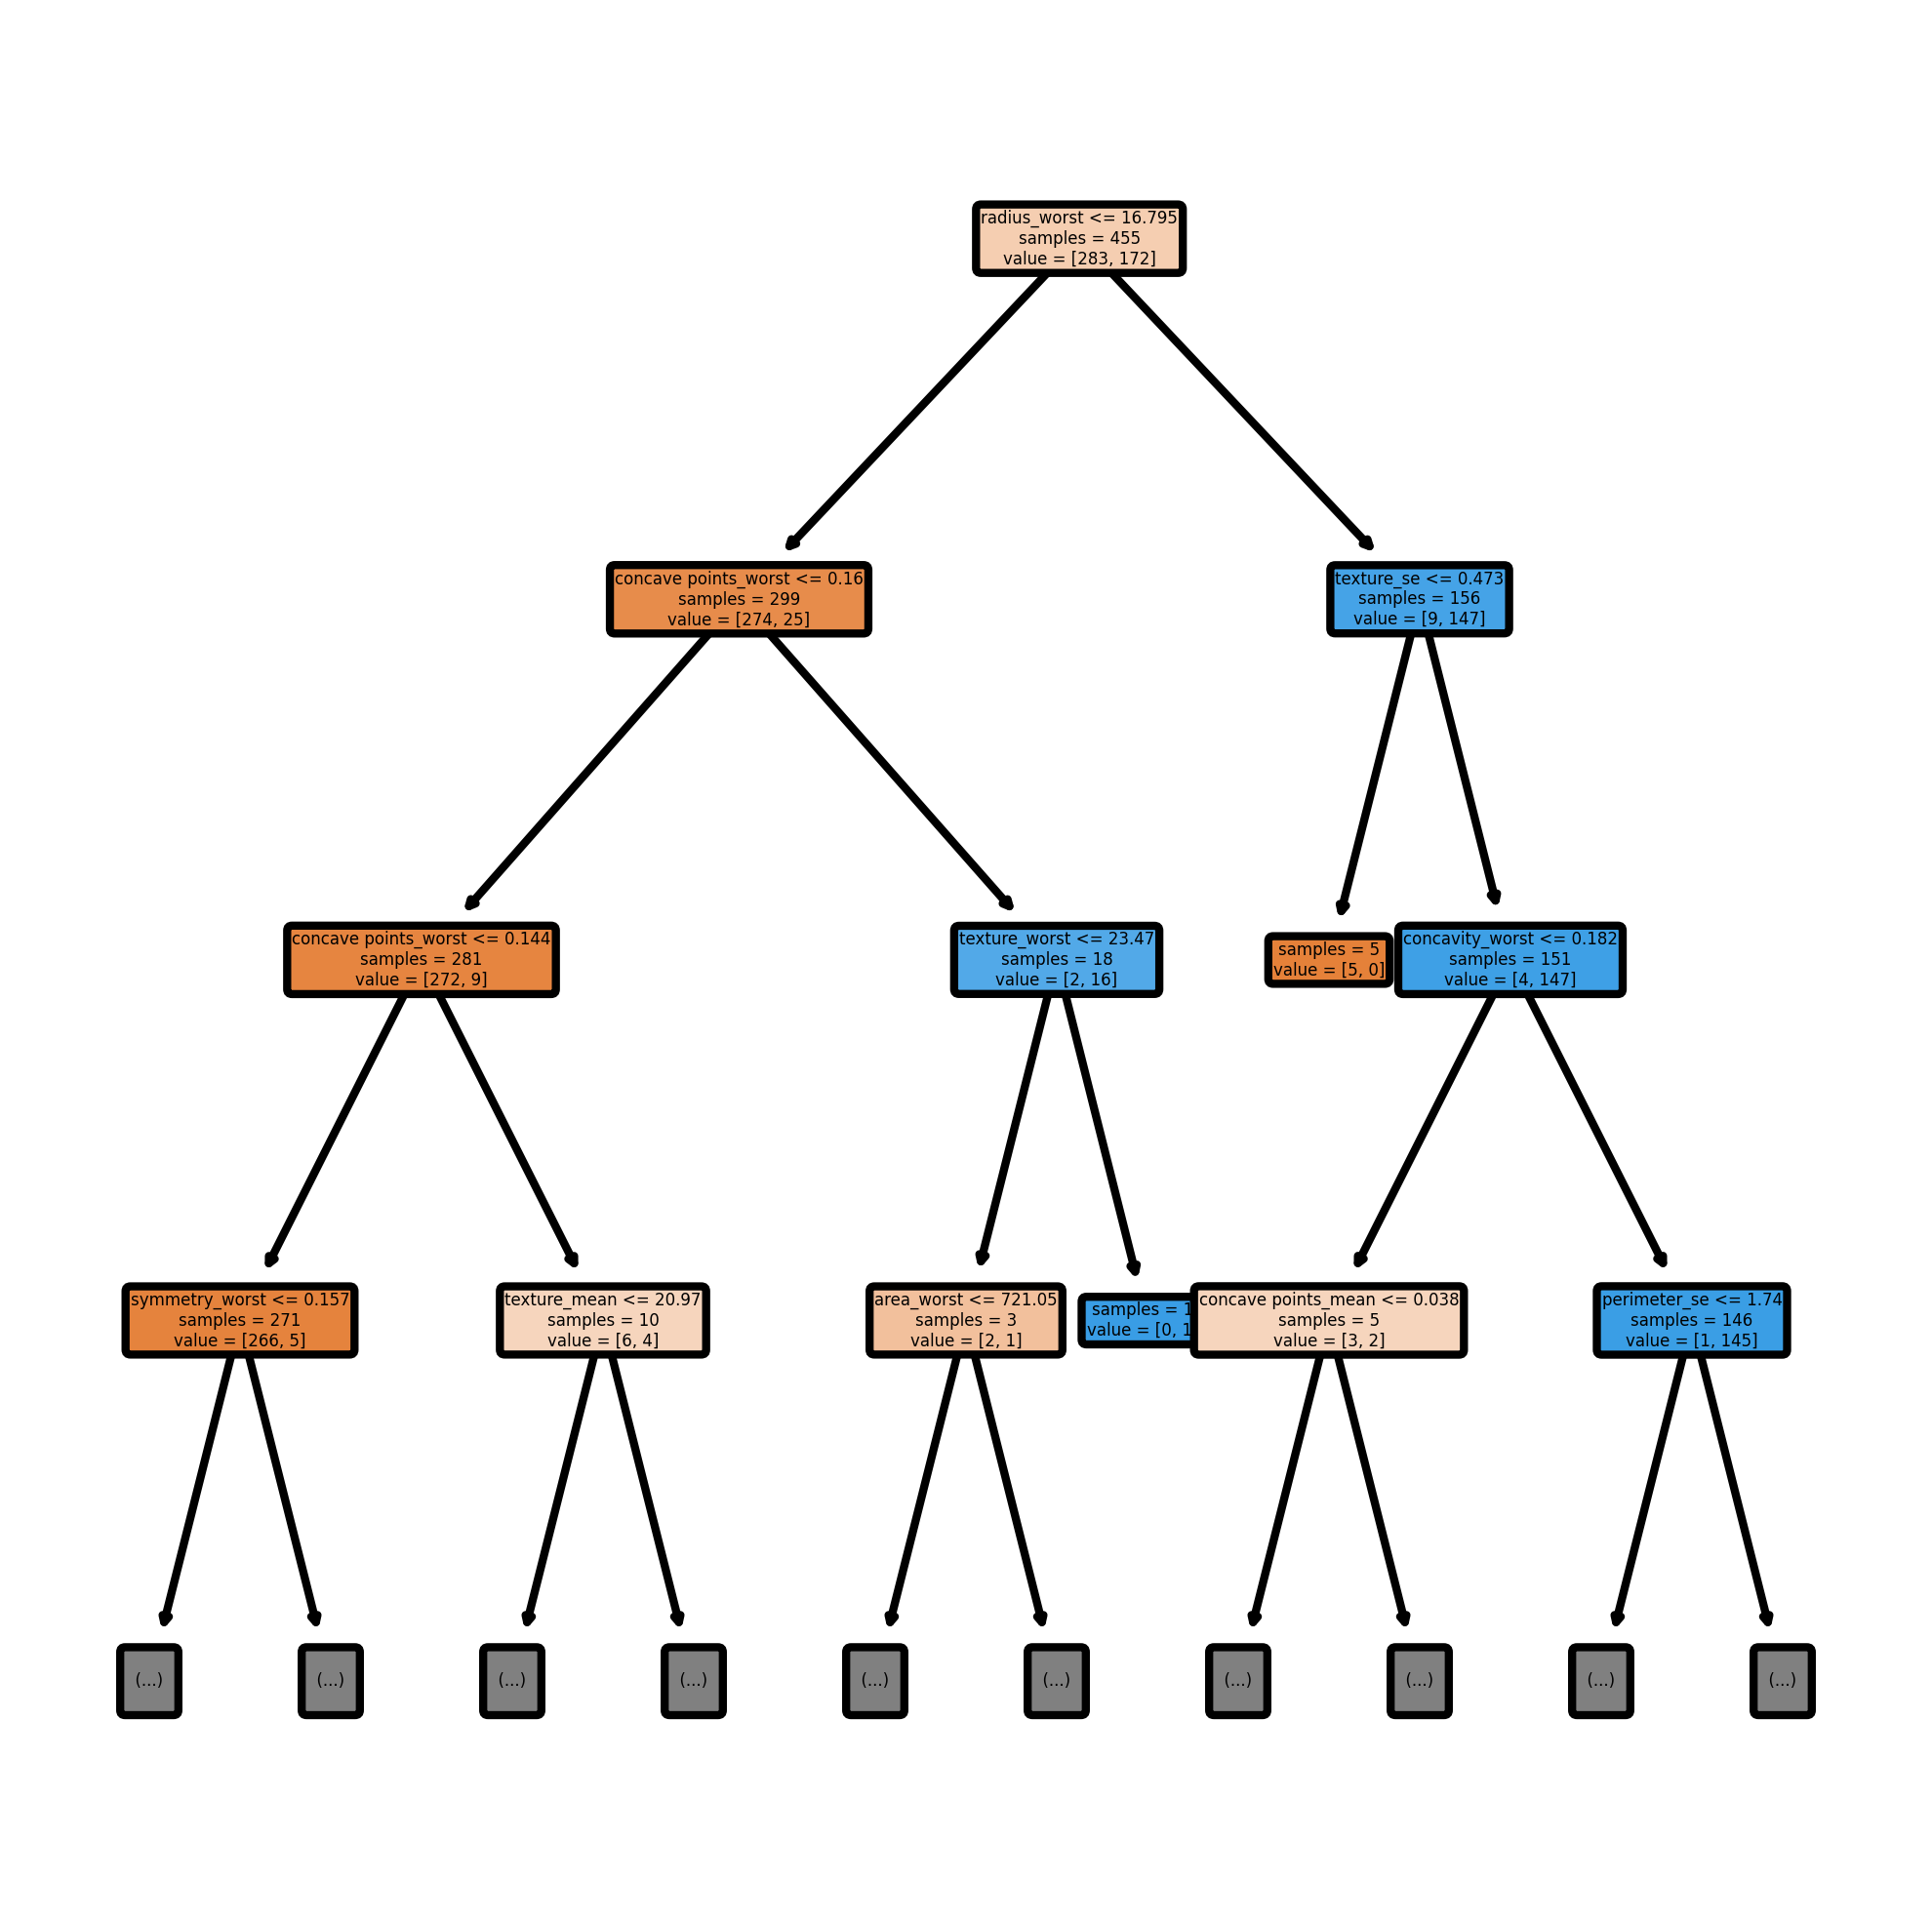

In [ ]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=600)
tree.plot_tree(decision_tree,
           feature_names = list(X.columns),
           filled = True,
           max_depth=3,
           fontsize=2,
           rounded=True,
           impurity=False);

You can see the feature name and the split at each node value. At the top we have radius_worst, which means that it is the best feature to split the data. As we go lower in the tree we find the best feature to split that subset of the data, and so on.

Finally, we need to test our decision tree. Let's test it using that subset of examples we saved for testing.

In [ ]:
decision_tree.score(X_test, y_test)

0.9122807017543859

So the decision tree has a 91% accuracy on the test data. That's not bad!

### Random Forest
You can think of a [random forest](https://towardsdatascience.com/understanding-random-forest-58381e0602d2) as a forest of decision trees. Each tree is given a set of parameters it can use to make a prediction, and after they have all completed they vote to choose the actual prediction. Random forests have two important [hyperparameters](https://www.techopedia.com/definition/34625/hyperparameter-ml-hyperparameter) that we have to modify to suit our data correctly. These hyperparameters are the maximum depth of every tree, and the number of trees we choose to have. The depth of the tree is very important to consider since we would like to avoid a pitfall known as [overfitting](https://www.datarobot.com/wiki/overfitting/), where our decision trees have so many layers that they can predict the training set perfectly, but they don't do so well at predicting new data (which is the whole point).

Since these hyperparameters are so important, we have created a function to find the best hyperparameters for a model. Using a [grid search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html), we can choose the best combination of hyperparameters for our models.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

def fit_score_model(name, model, params, X_in, y_in):
    scoring = ['f1_macro', 'accuracy']
    # Find the best model in terms of accuracy
    clf = GridSearchCV(model, params, scoring=scoring, cv=10, refit='accuracy').fit(X_in, y_in)
    best_model = clf.best_estimator_
    best_params = clf.best_params_
    # Score the model with 10-fold cross validation
    scores = cross_validate(best_model, X_in, y_in, cv=10, scoring=scoring)
    # Calculate CV standard error estimates
    acc_mean = sum(scores['test_accuracy'])/10
    f1_mean = sum(scores['test_f1_macro'])/10
    
    # Print the results
    print(name)
    print('----------')
    print('Parameters')
    print(best_params)
    print(f'Accuracy (Average: {acc_mean})')
    print(scores['test_accuracy'])
    print(f'F1 Score (Average: {f1_mean})')
    print(scores['test_f1_macro'])
    print()
    
    # Return the best model and its scores
    return best_model, scores

Grid Search needs to test a classifier in a process called [cross validation](https://scikit-learn.org/stable/modules/cross_validation.html). We split the data into different training and test sets a certain number of times (in this case, 10, which means this is 10-fold cross validation). Then we test it with each split and compute an average. This will also be our main strategy for testing the effectiveness of our classification algorithms. We print it out the 10 scores we get at the end of the function.

Finally, we can give this function a decision tree and a range of parameters, and have it show us what the best parameters for our model are.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#knn_model, knn_scores_full = fit_score_model('K Nearest Neighbors', KNeighborsClassifier(), {'n_neighbors': range(1, 50)}, X_train, y_train)
rf_model, rf_scores = fit_score_model('Random Forest', RandomForestClassifier(), {'n_estimators': range(1, 10), 'max_depth': range(1, 10)}, X_train, y_train)

K Nearest Neighbors
----------
Parameters
{'n_neighbors': 1}
Accuracy (Average: 0.8197101449275361)
[0.82608696 0.84782609 0.80434783 0.84782609 0.80434783 0.8
 0.82222222 0.8        0.8        0.84444444]
F1 Score (Average: 0.7987073959399617)
[0.79464286 0.82375479 0.75283582 0.83461736 0.78106822 0.77856752
 0.81092437 0.784689   0.78961039 0.83636364]

Random Forest
----------
Parameters
{'max_depth': 9, 'n_estimators': 8}
Accuracy (Average: 0.953816425120773)
[0.93478261 0.97826087 0.95652174 0.93478261 0.97826087 0.93333333
 0.95555556 0.95555556 0.95555556 0.95555556]
F1 Score (Average: 0.9503666962231018)
[0.92702274 0.97637391 0.95334686 0.93082707 0.97694236 0.92822967
 0.95273109 0.95273109 0.95273109 0.95273109]



That seems pretty good! Now let's test it on the actual testing data.

In [ ]:
rf_model.score(X_test, y_test)

0.9298245614035088

Seems like the accuracy went down slightly. We may have a small case of overfitting, but since the accuracy is already pretty high this is probably fine.

## K Nearest Neighbors
In the data exploration section, it is clear that the benign and malignant cells group themselves pretty distinctly in all categories. So it is very likely that if we plot the data points of a new cell, and that data point is surrounded by data points that belong to benign cells, then the new cell is also benign. This simple assumption defines the strategy of the [K Nearest Neighbors Algorithm](https://towardsdatascience.com/machine-learning-basics-with-the-k-nearest-neighbors-algorithm-6a6e71d01761).

However, just like the random forest, the K Nearest Neighbors algorithm has an important hyperparameter, which is the number of neighbors to consider. Using grid search again, we can find the best number of neighbors.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_model, knn_scores = fit_score_model('K Nearest Neighbors', KNeighborsClassifier(), {'n_neighbors': range(1, 30)}, X_train, y_train)

K Nearest Neighbors
----------
Parameters
{'n_neighbors': 6}
Accuracy (Average: 0.9296135265700484)
[0.95652174 0.95652174 0.89130435 0.91304348 0.95652174 0.84444444
 1.         0.88888889 0.95555556 0.93333333]
F1 Score (Average: 0.9214155019728174)
[0.95053763 0.95208333 0.87411056 0.90416667 0.95208333 0.82777474
 1.         0.87698196 0.95273109 0.9236857 ]



Now we can test this model with test set as before.

In [ ]:
knn_model.score(X_test, y_test)

0.9385964912280702

It looks like KNN does even better than a random forest!

In [ ]:
from scipy import stats

_, p1 = stats.ttest_ind(knn_scores_full['test_accuracy'], rf_scores_full['test_accuracy'])
_, p2 = stats.ttest_ind(knn_scores_full['test_f1_macro'], rf_scores_full['test_f1_macro'])
print(f'Accuracy P-value: {p1}')
print(f'F1-score P-value: {p2}')

Accuracy P-value: 0.009172673058179367
F1-score P-value: 0.009793543238972134


The distributions are very different (obviously)

###Naive Bayes
The Naive Bayes classifier is slightly different from the previous ones. The Naive Bayes classifier relies on patterns with certain features (ie. If this is the value for feature X, Y, Z, then what is the likelihood that the classification is A vs B?). There are several different types of [Naive Bayes classifiers](https://towardsdatascience.com/naive-bayes-classifier-81d512f50a7c) but they all rely on the same Naive Bayes assumption. We will withhold from going into the details here, and instead focus on applying the Naive Bayes classifier to our cancer dataset.

Since we don't have any hyperparameters to tune here, we will just go ahead and apply the cross_validate function directly on our models.

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB

In [ ]:
# naive bayes
gnb = GaussianNB().fit(X_train, y_train)
scores = cross_validate(gnb, X_train, y_train, cv=10)["test_score"]
print(scores)
print("Naive bayes has %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

[0.91304348 0.93478261 0.95652174 0.95652174 0.97826087 0.91111111
 0.93333333 0.93333333 0.93333333 0.93333333]
Naive bayes has 0.94 accuracy with a standard deviation of 0.02


In [ ]:
# naive bayes for multimonially distributed data
X = cc.drop(['Malignant', 'Benign'], axis=1) # The data used for training
y = cc['Malignant'] # The actual labels
mnb = MultinomialNB(force_alpha=True).fit(X_train, y_train)
scores = cross_validate(mnb, X_train, y_train, cv=10)["test_score"]
print(scores)
print("Multinominal naive bayes has %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

[0.95652174 0.89130435 0.86956522 0.93478261 0.89130435 0.84444444
 0.86666667 0.82222222 0.95555556 0.91111111]
Multinominal naive bayes has 0.89 accuracy with a standard deviation of 0.04


In [ ]:
# naive bayes for multinominally distributed imbalanced data
cnb = ComplementNB(force_alpha=True).fit(X_train, y_train)
scores = cross_validate(cnb, X_train, y_train, cv=10)["test_score"]
print(scores)
print("Complement naive bayes has %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

[0.95652174 0.89130435 0.89130435 0.93478261 0.89130435 0.86666667
 0.86666667 0.82222222 0.95555556 0.91111111]
Complement naive bayes has 0.90 accuracy with a standard deviation of 0.04


Finally, we can test each of them on the testing subset.

In [ ]:
print(gnb.score(X_test, y_test))
print(mnb.score(X_test, y_test))
print(cnb.score(X_test, y_test))

0.9385964912280702
0.8947368421052632
0.8771929824561403


So they are each not too far off from their respective training scores. Looks like the Gaussian model did the best.

### Logistic Regression
[Logistic Regression](https://aws.amazon.com/what-is/logistic-regression/) is another machine learning technique. Using a function called a sigmoid which returns a value between 0 and 1, the logistic regression model can make estimates about the value of the dependent variable (in this case, the benign or malignant cell).

In [ ]:
from sklearn.linear_model import LogisticRegression

One thing we can change within logistic regression is the maximum number of iterations that the model goes through. As the model uses more iterations, it can gain more accuracy on the training set. However with too many iterations we can run into the problem of overfitting again. To avoid this, we use cross validation again to make sure the accuracies stay high.

In [ ]:
# logistic regression with no regularizer
lrg_np_100 = LogisticRegression(penalty=None, random_state=10, solver="saga").fit(X_train, y_train)
lrg_np_500 = LogisticRegression(penalty=None, random_state=10, solver="saga", max_iter=500).fit(X_train, y_train)
scores_100 = cross_validate(lrg_np_100, X_train, y_train, cv=10)["test_score"]
scores_500 = cross_validate(lrg_np_500, X_train, y_train, cv=10)["test_score"]
print("Logistic regression with no penalty and 100 max iteration has %0.2f accuracy with a standard deviation of %0.2f" % (scores_100.mean(), scores_100.std()))
print("Logistic regression with no penalty and 500 max iteration has %0.2f accuracy with a standard deviation of %0.2f" % (scores_500.mean(), scores_500.std()))

Logistic regression with no penalty and 100 max iteration has 0.91 accuracy with a standard deviation of 0.03
Logistic regression with no penalty and 500 max iteration has 0.92 accuracy with a standard deviation of 0.02


It seems like adding more iterations does not help with converging, though it increases both the average accuracy and the standard deviation of the accuracy. Something else we can try is adding a [regularizer](https://towardsdatascience.com/regularization-in-machine-learning-76441ddcf99a). Regularizers provide another way to curb the problem of overfitting. By making sure coefficients stay lower, we can avoid learning a model that is too overly complex. This keeps the model more likely to be correct for unknown data.

There are several different types of regularizers, however we use an l1 and an l2 regularizer to test in this case.

In [ ]:
# logistic regression with l1 regularizer
lrg_l1_100 = LogisticRegression(penalty = "l1", random_state=10, solver="saga").fit(X_train, y_train)
lrg_l1_500 = LogisticRegression(penalty = "l1", random_state=10, solver="saga", max_iter=500).fit(X_train, y_train)
scores_100 = cross_validate(lrg_l1_100, X_train, y_train, cv=10)["test_score"]
scores_500 = cross_validate(lrg_l1_500, X_train, y_train, cv=10)["test_score"]
print("Logistic regression with l1 regularizer and 100 max iteration has %0.2f accuracy with a standard deviation of %0.2f" % (scores_100.mean(), scores_100.std()))
print("Logistic regression with l1 regularizer and 500 max iteration has %0.2f accuracy with a standard deviation of %0.2f" % (scores_500.mean(), scores_500.std()))

Logistic regression with l1 regularizer and 100 max iteration has 0.91 accuracy with a standard deviation of 0.03
Logistic regression with l1 regularizer and 500 max iteration has 0.92 accuracy with a standard deviation of 0.02


In [ ]:
# logistic regression with l2 regularizer
lrg_l2_100 = LogisticRegression(penalty = "l2", random_state=10, solver="saga").fit(X_train, y_train)
lrg_l2_500 = LogisticRegression(penalty = "l2", random_state=10, solver="saga", max_iter=500).fit(X_train, y_train)
scores_100 = cross_validate(lrg_l2_100, X_train, y_train, cv=10)["test_score"]
scores_500 = cross_validate(lrg_l2_500, X_train, y_train, cv=10)["test_score"]
print("Logistic regression with l2 regularizer and 100 max iteration has %0.2f accuracy with a standard deviation of %0.2f" % (scores_100.mean(), scores_100.std()))
print("Logistic regression with l2 regularizer and 500 max iteration has %0.2f accuracy with a standard deviation of %0.2f" % (scores_500.mean(), scores_500.std()))

Logistic regression with l2 regularizer and 100 max iteration has 0.91 accuracy with a standard deviation of 0.03
Logistic regression with l2 regularizer and 500 max iteration has 0.92 accuracy with a standard deviation of 0.02


So it doesn't seem like the accuracy changed much at all. Let's see if the coefficients went down as we expected them to.

In [ ]:
lrg_np_coef = lrg_np_500.coef_
lrg_l1_coef = lrg_l1_500.coef_
lrg_l2_coef = lrg_l2_500.coef_
print("Logistic regression with no penalty has weights: ",lrg_np_coef, " which sums to ", np.sum([abs(i) for i in lrg_np_coef]))
print("Logistic regression with l1 regularizer has weights: ",lrg_l1_coef, " which sums to ", np.sum([abs(i) for i in lrg_l1_coef]))
print("Logistic regression with l2 regularizer has weights: ",lrg_l2_coef, " which sums to ", np.sum([abs(i) for i in lrg_l2_coef]))

Logistic regression with no penalty has weights:  [[-6.82431959e-03 -1.07007110e-02 -3.96780293e-02 -1.71303446e-02
  -6.62985979e-05  2.31964998e-05  1.10491554e-04  5.06584353e-05
  -1.32107301e-04 -5.34672506e-05 -6.60875043e-05 -8.32235916e-04
  -4.04663552e-05  1.23155445e-02 -5.72742215e-06  2.25299066e-07
   9.40800261e-07 -4.68083358e-07 -1.56201395e-05 -1.88465117e-06
  -7.04887273e-03 -1.31148579e-02 -3.90875712e-02  2.29297650e-02
  -8.20678556e-05  1.26594724e-04  2.44802186e-04  6.38356579e-05
  -1.77607027e-04 -4.79521089e-05]]  which sums to  0.17097275120688815
Logistic regression with l1 regularizer has weights:  [[-6.78798429e-03 -1.06695483e-02 -3.96625903e-02 -1.71159384e-02
  -2.59354402e-05  1.38567070e-06  7.01015577e-05  1.02615738e-05
  -9.17864398e-05 -1.30933613e-05 -2.56840686e-05 -7.92571534e-04
  -7.43776593e-08  1.22864828e-02  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -7.01240833e-03 -1.30865399e-0

The weights seemed to have lowered slightly for the L1 case. Finally, we need to test the fitted models on the test dataset again.

In [ ]:
print(lrg_np_500.score(X_test, y_test))
print(lrg_l1_500.score(X_test, y_test))
print(lrg_l2_500.score(X_test, y_test))

0.9210526315789473
0.9210526315789473
0.9210526315789473


It looks like the regularizer made no noticable difference. This could be for a number of reasons, but the most likely reason seems to be that the training and testing data have very similar distributions, which means we have a much lesser chance of overfitting.

### Feedforward Neural Network (FNN)
A [feedforward neural network](https://deepai.org/machine-learning-glossary-and-terms/feed-forward-neural-network) is a machine learning algorithm that processes input data by passing it through a series of interconnected layers until it reaches the output layer, where it produces the model's prediction. Neural networks are highly versatile and can be used for a wide range of tasks, including classification and regression. They excel at capturing complex patterns and can adapt to a variety of problem domains. Though it has some limitations,  the first of which is that it can become computationally intensive depending on the dimensionality of the input, number of layers, and neurons. Another issue is how easily it can overfit to the training data if the dataset's complexity is not proportional to the model's.

From our data exploration, we can observe some distinct patterns with clear separation between classes. Based on this, we can expect that there is a considerable degree of linear separability without significant overlap in the data. Therefore, a simple model would likely suffice to achieve accurate predictions. It may even be possible to use a single-layer perceptron if a hyperplane can accurately separate the classes. 

In [ ]:
# imports 
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import cross_val_score
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2, l1
from sklearn.model_selection import train_test_split
tf.keras.utils.disable_interactive_logging()
from sklearn.metrics import classification_report


Again, we would like to evaluate the training of our model using KFold Cross Validation.

In [ ]:
# K-fold cross validation since we have a small dataset
kf = KFold(n_splits=10, shuffle=True, random_state=4)

In [ ]:
def get_col_wise_avg(matrix):
    num_rows = len(matrix)
    num_cols = len(matrix[0])
    col_averages = []

    for col in range(num_cols):
        col_sum = sum(matrix[row][col] for row in range(num_rows))
        col_avg = col_sum / num_rows
        col_averages.append(col_avg)
    return col_averages

Let's start by training the model. We need to manually train it on each fold since we are using TensorFlow for this one.

his Neural network has 2 hidden layers which are each using the [ReLU](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/) activation function with an l1 regularizer. Finally the output is computed using the sigmoid function. 

Finally, we need a way to update the weights after making a prediction. This is where the optimizer comes in. Our model uses the adam optimizer, and the binary crossentropy loss function.

In [ ]:
# Train the model and evaluate it for each fold
scores = []
for x in range(10):
  # Builds the model layer by layer
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(9, activation='relu',kernel_regularizer=l1(0.01)),
    Dropout(0.2),
    tf.keras.layers.Dense(9, activation='relu',kernel_regularizer=l1(0.01)),
    tf.keras.layers.Dense(1, activation='sigmoid')])
  # Compiles the model
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  model.fit(X_train, y_train, epochs=10,batch_size=7, verbose=0)
  y_pred = model.predict(X_test)
  y_pred = np.round(y_pred)
  scores.append(accuracy_score(y_test, y_pred))

avg_acc = sum(scores) / len(scores)


In [ ]:
print(f"individual model accuracy: {scores}")
print(f"average model accuracy: {avg_acc}")


individual model accuracy: [0.9298245614035088, 0.9035087719298246, 0.7280701754385965, 0.9210526315789473, 0.9035087719298246, 0.9035087719298246, 0.9122807017543859, 0.9210526315789473, 0.8508771929824561, 0.8859649122807017]
average model accuracy: 0.8859649122807017


In [ ]:
# k-fold cross validation with sklearn
# for each k-folds find its avg and find the k with the best average 
def optim_folds(X,y, min, max, step):
    k = []
    models = []
    # Loop through the number of folds
    while min < max:
        # Builds the model 
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(9, activation='relu',kernel_regularizer=l1(0.01)),
            Dropout(0.2),
            tf.keras.layers.Dense(9, activation='relu',kernel_regularizer=l1(0.01)),
            tf.keras.layers.Dense(1, activation='sigmoid')])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


        kf = KFold(n_splits=min, shuffle=True, random_state=4)
        scores = []
        # Train the model and evaluate it for each fold
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]


            model.fit(X_train, y_train, epochs=10,batch_size=7, verbose=0)
            y_pred = model.predict(X_test)
            y_pred = np.round(y_pred)
            scores.append(accuracy_score(y_test, y_pred))
        k.append(sum(scores) / len(scores))
        models.append(model)
        min += step
    # Returns the final accuracy and model for each n-folds
    return k, models

In [ ]:
# Runs the function
# be careful, this takes a while to run
fold_x = [i for i in range(2, 100, 5)]
scores, models = optim_folds(X,y, 2, 100, 5)

Text(0.5, 0, 'Number of folds')

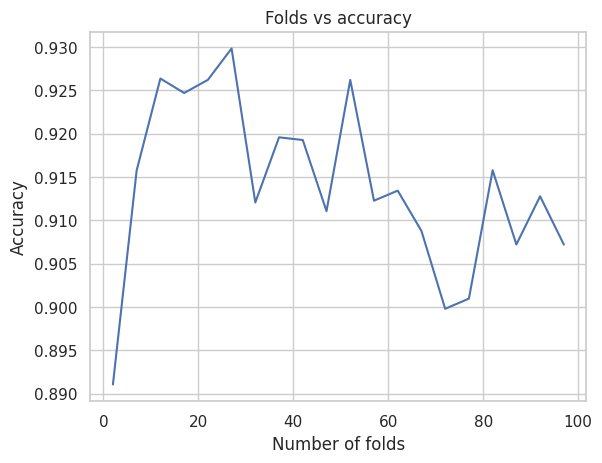

In [ ]:
# Plot the accuracy for each n-folds
plt.plot(fold_x, scores)
plt.title('Folds vs accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of folds')


While the plot displays the average testing accuracy for each k-fold cross-validation, it is important to remember that achieving a high testing accuracy does not necessarily indicate a good model. However, we do observe that as the number of folds increases, there is a slight drop in testing accuracy. It is unclear if this trend will continue as k increases.

It is interesting to see because as k increases, the model is trained on a more diverse set of data, so we would expect more generalization. However, due to our dataset containing only 600 examples, in the case of using 50 folds, each fold only contains around 12 examples. This small validation size in each fold can reduce the reliability of the accuracy estimate, especially since each fold is weighed equally in the evaluation.



<h2> Tuning the architecture of the Neural Network </h2>
When using TensorFlow's sequnetial module to develople the architecture for your neural networks you will need to optimise your hyperparameters for your problem and dataset.  

What we know:
*   Using ReLU activation functions for each fully connected hidden layer can help prevent vanishing gradients, since the range is unbounded on the right but capped at 0 on the left. 
*   Using a single neuron with the sigmoid activation function in the output layer is a common approach for binary classification tasks, as it allows us to directly access the model's probability estimate for the positive class.
*   We will be using the adam optmiser which uses past past and current gradeints to change the learning rates. This improves trainng times. 
*   Since it is a binary classification task we will be using binary cross entropy loss.   

The hyperparameters we need to test: 

*   The number of hidden layers 
*   The number of neurons per layer
*   The loss function 
*   Number of epochs 






In [ ]:
# Hyperparameter tuning

# Optimizing the number of layers
def optim_layers(X_train, y_train, X_test, y_test, num_layers_min, num_layers_max, num_layers_step):
  tot_loss = []
  for x in range(10):
    layers = [tf.keras.layers.Dense(10, activation='relu')]
    losses = []
    for num_layers in range(num_layers_min, num_layers_max, num_layers_step):
        layers += [tf.keras.layers.Dense(10, activation='relu') for _ in range(num_layers)]
        layers.append(tf.keras.layers.Dense(1, activation='sigmoid'))
        model = tf.keras.Sequential(layers)
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        model.fit(X_train, y_train, epochs=10, batch_size=7, verbose=0)
        model.reset_states()
        loss, acc = model.evaluate(X_test, y_test, verbose=0)
        losses.append(loss)
    tot_loss.append(losses)
  return get_col_wise_avg(tot_loss)
    
# Optimizing the number of neurons
def optim_neurons(X_train,y_train,X_test,y_test, min, max, step):
  tot_loss = []
  for x in range(10):
    idx = min
    losses = []
    while idx < max:
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(9, activation='relu',kernel_regularizer=l1(0.01)),
            Dropout(0.2),
            tf.keras.layers.Dense(9, activation='relu',kernel_regularizer=l1(0.01)),
            tf.keras.layers.Dense(1, activation='sigmoid')])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        model.fit(X_train, y_train, epochs=10,batch_size=7, verbose=0)
        loss, acc = model.evaluate(X_test, y_test, verbose=0)
        losses.append(loss)
        idx += step
    tot_loss.append(losses)
  return get_col_wise_avg(tot_loss)

# Optimizing the batch size
def optim_batch(X_train,y_train,X_test,y_test, min, max, step):
  tot_loss = []
  for x in range(10):
    idx = min
    losses = []
    while idx < max:
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(9, activation='relu',kernel_regularizer=l1(0.01)),
            Dropout(0.2),
            tf.keras.layers.Dense(9, activation='relu',kernel_regularizer=l1(0.01)),
            tf.keras.layers.Dense(1, activation='sigmoid')])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        model.fit(X_train, y_train, epochs=10,batch_size=min, verbose=0)
        loss, acc = model.evaluate(X_test, y_test, verbose=0)
        losses.append(loss)
        idx += step
    tot_loss.append(losses)
  return get_col_wise_avg(tot_loss)

    
# Optimizing the number of epochs
def optim_epochs(X_train,y_train,X_test,y_test, min, max, step):
  tot_loss = []
  for x in range(10):
    idx = min
    losses = []
    while idx < max:
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(9, activation='relu',kernel_regularizer=l1(0.01)),
            Dropout(0.2),
            tf.keras.layers.Dense(9, activation='relu',kernel_regularizer=l1(0.01)),
            tf.keras.layers.Dense(1, activation='sigmoid')])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        model.fit(X_train, y_train, epochs=min,batch_size=7, verbose=0)
        loss, acc = model.evaluate(X_test, y_test, verbose=0)
        losses.append(loss)
        idx += step
    tot_loss.append(losses)
  return get_col_wise_avg(tot_loss)

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.4)

In [ ]:
# We are testing given the average of 10 interations what is the loss 
# given the number of layers. We expect that lower is better 
num_layers = optim_layers(X_train,y_train,X_test,y_test, 1, 10, 1)

In [ ]:
# given the three layer model, what is the number of nerons that acheives the 
# least amount of loss
num_neurons = optim_neurons(X_train,y_train,X_test,y_test, 1, 60, 1)

In [ ]:
# Comparing the batch size, we expect that lower will coverge slower, and there 
# will be more variance which is sometimes good for generalizeation.
# Larger will converge faster but will have lower variance  
num_batch = optim_batch(X_train,y_train,X_test,y_test, 1, 10, 2)
xaxis_batch = []
x=1
while x < 10:
  xaxis_batch.append(x)
  x += 2

In [ ]:
# Comparing the average loss, given the number of epochs. We expect as the 
# number of epoch to increase the testing loss should also increase, since 
# it allows more time for the model to overfit. 
num_epochs = optim_epochs(X_train,y_train,X_test,y_test, 1, 100, 3)
xaxis_epoch = []
x=1
while x < 100:
  xaxis_epoch.append(x)
  x += 3

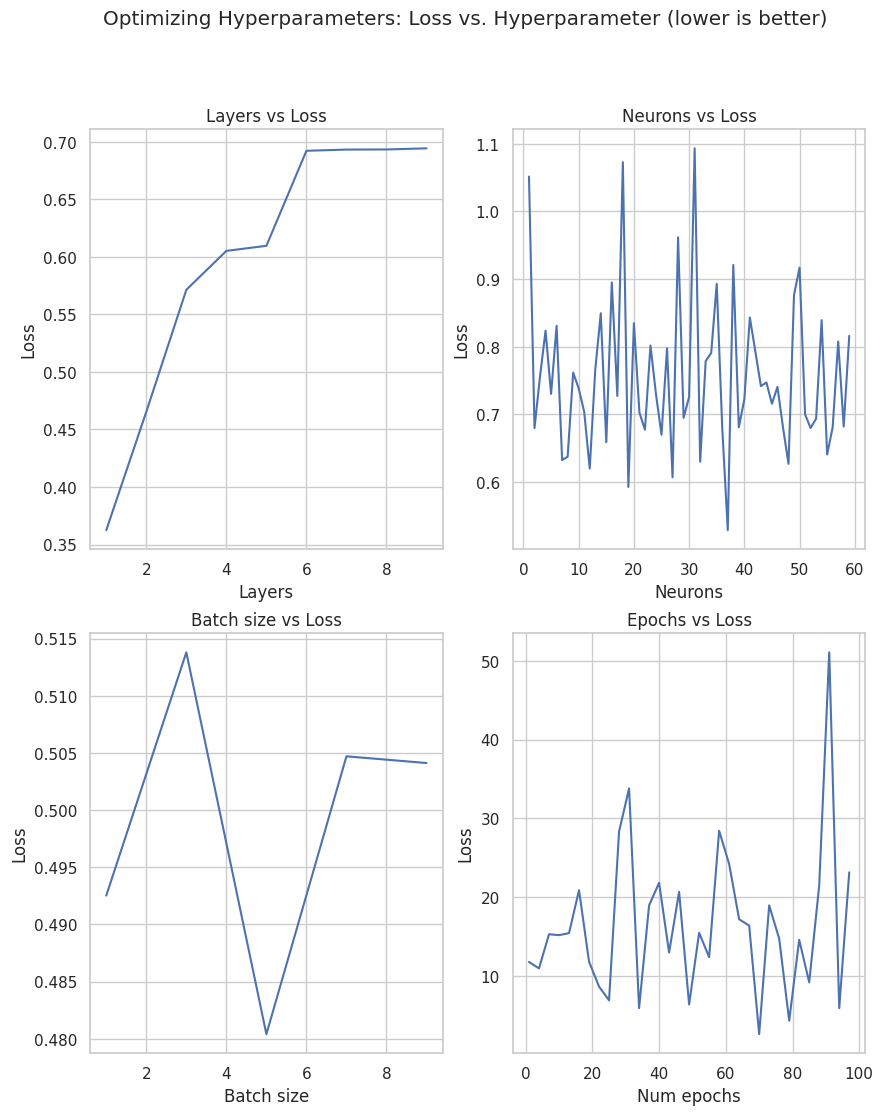

In [ ]:
layerx = [x+1 for x in range(9)]
fig, axs = plt.subplots(nrows= 2, ncols=2, figsize=(10,12))
axs[0,0].plot(layerx, num_layers)
axs[0,0].set_title('Layers vs Loss')
axs[0,0].set_xlabel('Layers')
axs[0,0].set_ylabel('Loss')

neuronx = [x+1 for x in range(len(num_neurons))]
axs[0,1].plot(neuronx, num_neurons)
axs[0,1].set_title('Neurons vs Loss')
axs[0,1].set_xlabel('Neurons')
axs[0,1].set_ylabel('Loss')

axs[1,0].plot(xaxis_batch, num_batch)
axs[1,0].set_title('Batch size vs Loss')
axs[1,0].set_xlabel('Batch size')
axs[1,0].set_ylabel('Loss')

axs[1,1].plot(xaxis_epoch, num_epochs)
axs[1,1].set_title('Epochs vs Loss')
axs[1,1].set_xlabel('Num epochs')
axs[1,1].set_ylabel('Loss')

fig.suptitle('Optimizing Hyperparameters: Loss vs. Hyperparameter (lower is better)')
plt.show()


From these plots above and prior we can make a couple of assumptions on how to best make our model. First if you choose to use KFold to evaluate your model it is good to use a k around 20. As for the model's archtcture, In the hyperparameter tuning plot we can see the best number of hidden layers is one, but the number of neurons at most ranges has allot of variance but the lowest point is around 37 neurons, which makes sence since it is close to the dimensionality of the dataset. The number of Epochs is the most uniterpretable plot, but we can see high variance at the end but this may be a fluke and not be representavie of the model's general behavior. 

In [ ]:

# Comparing regularizers

kf = KFold(n_splits=21, shuffle=True, random_state=4)
train_loss_1 = []
train_loss_2 = []
train_loss_3 = []


scores1 = []
scores2 = []
scores3 = []
for train_index, test_index in kf.split(X):
    model1 = tf.keras.Sequential([
      tf.keras.layers.Dense(37, activation='relu',kernel_regularizer=l2(0.01)),
      tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model2 = tf.keras.Sequential([
        tf.keras.layers.Dense(37, activation='relu',kernel_regularizer=l1(0.01)),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model3 = tf.keras.Sequential([
        tf.keras.layers.Dense(37, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


    history1 = model1.fit(X_train, y_train, epochs=15,batch_size=3, verbose = 0)
    history2 = model2.fit(X_train, y_train, epochs=15,batch_size=3, verbose = 0)
    history3 = model3.fit(X_train, y_train, epochs=15,batch_size=3, verbose = 0)

    training_loss1 = history1.history['accuracy']
    training_loss2 = history2.history['accuracy']
    training_loss3 = history3.history['accuracy']
    train_loss_1.append(training_loss1)
    train_loss_2.append(training_loss2)
    train_loss_3.append(training_loss3)

    y_pred1 = model1.predict(X_test)
    y_pred2 = model2.predict(X_test)
    y_pred3 = model3.predict(X_test)

    y_pred1 = np.round(y_pred1)
    y_pred2 = np.round(y_pred2)
    y_pred3 = np.round(y_pred3)

    scores1.append(accuracy_score(y_test, y_pred1))
    scores2.append(accuracy_score(y_test, y_pred2))
    scores3.append(accuracy_score(y_test, y_pred3))

scores1 = sum(scores1) / len(scores1)
scores2 = sum(scores2) / len(scores2)
scores3 = sum(scores3) / len(scores3)

reg_scores = [scores1,scores2,scores3]
reg_labels = ['L2','L1','None']

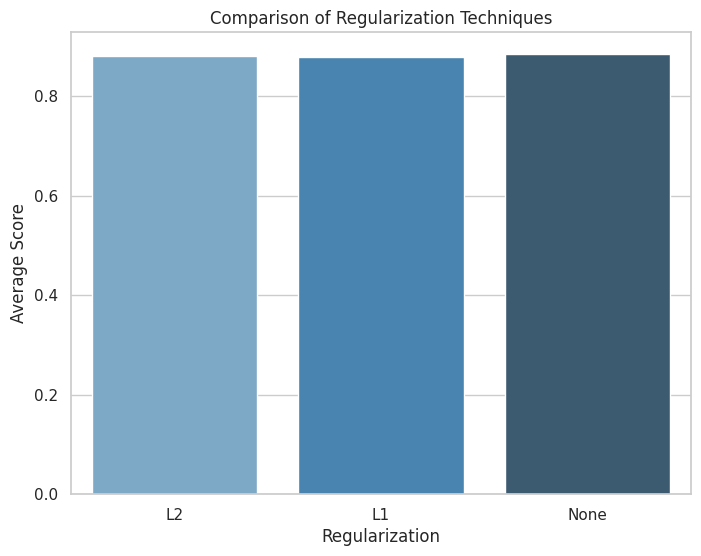

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=reg_labels, y=reg_scores, palette="Blues_d")
ax.set_xlabel("Regularization")
ax.set_ylabel("Average Score")
ax.set_title("Comparison of Regularization Techniques")
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.4)
normalizer = tf.keras.layers.Normalization(axis=-1)

# final Model 
final = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(37, activation='relu'),
    tf.keras.layers.Dense(37, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
final.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=20, mode = 'max')
history = final.fit(X_train,
                    y_train,
                    epochs=400,
                    verbose=0, 
                    batch_size=1, 
                    validation_split = 0.3, 
                    callbacks=[early_stopping])

<h2> Evaluating final model</h2>

<Axes: >

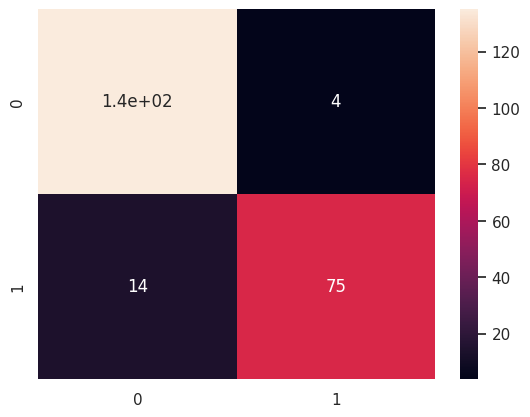

In [ ]:
y_pred =  np.round(final.predict(X_test)).astype(int)
cm = tf.math.confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)

In [ ]:
print(classification_report(y_test, y_pred))
test_loss, test_acc = final.evaluate(X_test, y_test)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       139
           1       0.95      0.84      0.89        89

    accuracy                           0.92       228
   macro avg       0.93      0.91      0.92       228
weighted avg       0.92      0.92      0.92       228

Test loss: 0.18745291233062744
Test accuracy: 0.9210526347160339


<h1>Support Vector Machine</h1>
Support vector machine, usually abbreviated as SVM, creates a decision boundary that best separates all the points into 2 classes by creating a linear or a non-linear decision boundary based on the kernal fuction. One of its feature are the margins that surround the decision boundary. The model's hyperparameter C determines the penalty given for misclassified examples, which can affect the size of the margins. Small C values give a larger margin since the penalty is small, while large C values give a smaller margin since the penalty is larger.

Another feature are the kernal functions that maps data from one space to another, and also determines the shape of the hyperplane and decision boundary. Some functions include linear, polynomial, RBF, and Gaussian.

In [ ]:
# Import libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import svm
from sklearn.model_selection import GridSearchCV

In [ ]:
# Seperate data from labels, and put labels into its own set
svm_x = cc.drop(['Benign','Malignant'], axis = 1)
svm_y = cc['Malignant']

# Split by 80-20
X_train, X_test, y_train, y_test = train_test_split(svm_x, svm_y, test_size=0.2, random_state = 1)

# Fit on RBF kernel
svc = svm.SVC(kernel = 'rbf')
svc.fit(X_train, y_train)

# print prediction results
predictions = svc.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93        72
           1       1.00      0.74      0.85        42

    accuracy                           0.90       114
   macro avg       0.93      0.87      0.89       114
weighted avg       0.92      0.90      0.90       114




Accuracy of the RBF kernal is 90%.


In [ ]:
# Fit on 2nd degree polynomial kernel
svc = svm.SVC(kernel = 'poly', degree = 2)
svc.fit(X_train, y_train)

# print prediction results
predictions = svc.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.86      1.00      0.92        72
           1       1.00      0.71      0.83        42

    accuracy                           0.89       114
   macro avg       0.93      0.86      0.88       114
weighted avg       0.91      0.89      0.89       114



The accuracy of the polynomial kernel is 89%.


In [ ]:
# Fit on linear kernel
svc = svm.SVC(kernel = 'linear')
svc.fit(X_train, y_train)

# print prediction results
predictions = svc.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        72
           1       1.00      0.88      0.94        42

    accuracy                           0.96       114
   macro avg       0.97      0.94      0.95       114
weighted avg       0.96      0.96      0.96       114



Accuracy of the linear kernal is 96%. Let's see if we can tune the hyperparameter C to the RBF kernel function.



In [ ]:

param_grid = {'C': [0.1, 1, 10, 100], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
  
grid = GridSearchCV(svc, param_grid, refit = True, verbose = 3)

grid.fit(X_train, y_train)
print(grid.best_params_)
print(grid.best_estimator_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.626 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.626 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.626 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.626 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.626 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.626 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.626 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.626 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.626 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.626 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.626 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

{'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.93      0.96      0.95        72
           1       0.93      0.88      0.90        42

    accuracy                           0.93       114
   macro avg       0.93      0.92      0.92       114
weighted avg       0.93      0.93      0.93       114



Text(0.5, 1.0, 'RBF Confusion Matrix')

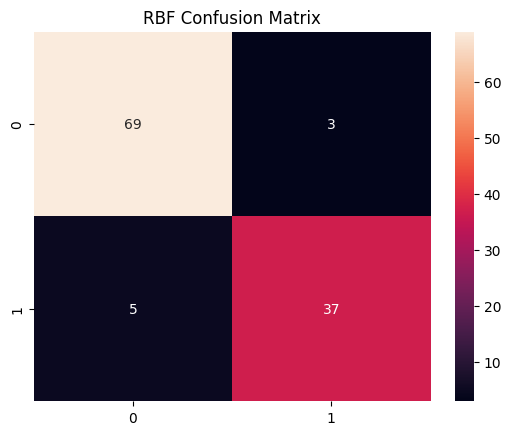

In [ ]:
# Print best parameter
print(grid.best_params_)
  
# Show accuracy 
grid_predictions = grid.predict(X_test)
print(classification_report(y_test, grid_predictions))

# Heatmap of confusion matrix
cm = confusion_matrix(y_test, grid_predictions)
sns.heatmap(cm, annot=True)
plt.title('RBF Confusion Matrix')

For the RBF kernel function, C = 100 was determined to be the best hyperparameter, when applied to the RBF SVM the accuracy is 93%.

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.901 total time=   0.1s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.923 total time=   0.4s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.978 total time=   0.1s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=1.000 total time=   0.2s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.978 total time=   0.0s
[CV 1/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.901 total time=   0.1s
[CV 2/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.923 total time=   0.4s
[CV 3/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.978 total time=   0.1s
[CV 4/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=1.000 total time=   0.2s
[CV 5/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.978 total time=   0.0s
[CV 1/5] END ..C=0.1, gamma=0.01, kernel=linear;, score=0.901 total time=   0.1s
[CV 2/5] END ..C=0.1, gamma=0.01, kernel=linear

Text(0.5, 1.0, 'Linear Confusion Matrix')

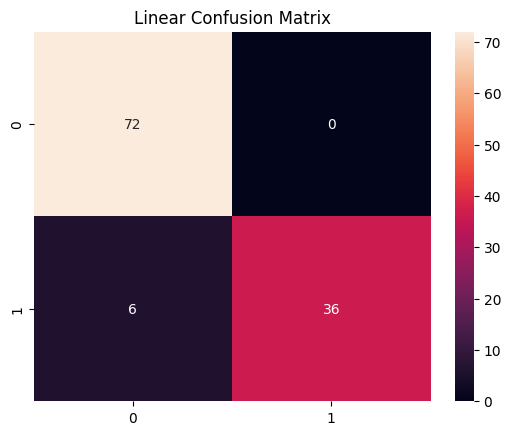

In [ ]:
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['linear']} 
  
grid = GridSearchCV(svc, param_grid, refit = True, verbose = 3)

grid.fit(X_train, y_train)
print(grid.best_params_)
print(grid.best_estimator_)

# Print best parameter
print(grid.best_params_)
  
# Show accuracy 
grid_predictions = grid.predict(X_test)
print(classification_report(y_test, grid_predictions))

# Heatmap of confusion matrix
cm = confusion_matrix(y_test, grid_predictions)
sns.heatmap(cm, annot=True)
plt.title('Linear Confusion Matrix')

<h2> Observation and Conclusion </h2>
<ol>
<li> Random Forest trained with features selected via PCA has the highest accuracy of about 97%. 
</li>
<li> PCA only has marginal effect on acuracy on all other ML algorithm. 
<ul> 
<li> One of the reasons might be no feature has dominating covariance with being benign over the covariance between other features and being benign. </li> <li> That means feature selection will not be as useful, except for random forest since random forest is prone to overfitting. </li>
</ul>
</li>
<li> Regularizer has insignificant effect on the weights of the features for Logistic Regression.
<ul>
<li> This result can be explained by the output of the cell below. </li>
<li> As we can see, almost all features are closed to being normalized. If the feature values are normalized, the weights associate with them can change dramastically since the gradient is small. </li>
<li> Maybe normalizing feature values can be a substitute of weight regularizer in some cases? </li>  
</ul>
</ul>
</li>
<li> SVM kernal functions also influences the accuracy of the SVM along with the hyper parameter C.
<ul>
<li> Since the tumor dataset was linearly seperable, the linear kernal function performed the best at classifying the data </li>
</ul>
</li>
</ol>

